In [104]:
import numpy as np 
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
import os
import sys
import sklearn
import os.path
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm

In [4]:
#np.random.seed(10)

In [5]:
def read_dataset(dataset_name):
    
    base_dir = os.path.dirname(os.path.realpath('__file__'))
    archive_name = 'UCRArchive'
    
    root_dir_dataset = base_dir + '/' + archive_name + '/' + dataset_name
    
    df_train = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TRAIN.tsv', sep='\t', header=None)
    
    df_test = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TEST.tsv', sep='\t', header=None)
    
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    x_train = df_train.drop(columns=[0])
    x_test = df_test.drop(columns=[0])
    
    x_train.columns = range(x_train.shape[1])
    x_test.columns = range(x_test.shape[1])
    
    x_train = x_train.values
    x_test = x_test.values
    
    
    labels = np.hstack((y_train, y_test)).astype(int)
    _, labels = np.unique(labels, return_inverse=True)
    features = np.vstack((x_train, x_test))
    
    
    n_ = features.shape[0]
    shuffle_id = np.random.permutation(np.arange(n_))
    Dataset = features[shuffle_id]
    label = labels[shuffle_id]
    
    return Dataset,label

In [6]:
class ArrhythmiaLoader(object):
    def __init__(self, dataset_name, N_train, mode="train"):
        self.mode=mode
        
        features,labels = read_dataset(dataset_name)

        N, D = features.shape
        
        normal_data = features[labels==0]
        normal_labels = labels[labels==0]

        N_normal = normal_data.shape[0]

        attack_data = features[labels==1]
        attack_labels = labels[labels==1]

        N_attack = attack_data.shape[0]

        randIdx = np.arange(N_attack)
        np.random.shuffle(randIdx)
        self.N_train = N_train
        self.train = attack_data[randIdx[:self.N_train]]
        self.train_labels = attack_labels[randIdx[:self.N_train]]
        
        self.test = attack_data[randIdx[self.N_train:]]
        self.test_labels = attack_labels[randIdx[self.N_train:]]
        
        self.test = np.concatenate((self.test, normal_data),axis=0)
        self.test_labels = np.concatenate((self.test_labels, normal_labels),axis=0)


    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return self.train.shape[0]
        else:
            return self.test.shape[0]


    def __getitem__(self, index):
        if self.mode == "train":
            return np.float32(self.train[index]), np.float32(self.train_labels[index])
        else:
            return np.float32(self.test[index]), np.float32(self.test_labels[index])  

In [7]:
def get_loader(dataset_name, batch_size, N_train, mode='train'):
    """Build and return data loader."""
    
    dataset = ArrhythmiaLoader(dataset_name, N_train, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader

In [8]:
def loss_function(recon_x, x, mu, logvar, enc, z,  enc_1, enc_2, enc_3, z_3, z_2, z_1):
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    criterion_elementwise_mean = nn.MSELoss(reduction='sum')
    BCE_x = criterion_elementwise_mean(recon_x,x)
    BCE_z = criterion_elementwise_mean(enc,z)
    BCE_z_1 = criterion_elementwise_mean(enc_1,z_1)
    BCE_z_2 = criterion_elementwise_mean(enc_2,z_2)
    BCE_z_3 = criterion_elementwise_mean(enc_3,z_3)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE_x + BCE_z + BCE_z_1 + BCE_z_2 + BCE_z_3 + KLD

In [904]:
dataset_name = 'ItalyPowerDemand'
batch_size = 32
learn_rate = 1e-4
Dataset,label = read_dataset(dataset_name)
All_train = Dataset.shape[0]

In [905]:
Dataset.shape

(1096, 24)

In [1262]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.enc_1 = nn.Linear(24,50)
        self.enc_2 = nn.Linear(50,50)
        self.enc_3 = nn.Linear(50,10)
        self.enc = nn.Linear(10,2)
        
        self.act = nn.ReLU()
        self.act_s = nn.Sigmoid()
        self.mu = nn.Linear(2,1)
        self.log_var = nn.Linear(2,1)
        
        self.z = nn.Linear(1,2)
        self.z_3 = nn.Linear(2,10)
        self.z_2 = nn.Linear(10,50)
        self.z_1 = nn.Linear(50,50)
        self.dec = nn.Linear(50,24)
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self,x):
        enc_1 = self.enc_1(x)
        enc_2 = self.act(enc_1)
        enc_2 = self.enc_2(enc_2)
        enc_3 = self.act(enc_2)
        enc_3 = self.enc_3(enc_3)
        enc = self.act(enc_3)
        enc = self.enc(enc_3)
        enc = self.act(enc)
        
        mu = self.mu(enc)
        log_var = self.log_var(enc)
        o = self.reparameterize(mu,log_var)
        z = self.z(o)
        z_3 = self.z_3(z)
        z_2 = self.act(z_3)
        z_2 = self.z_2(z_2)
        z_1 = self.act(z_2)
        z_1 = self.z_1(z_1)
        dec = self.dec(z_1)
        return enc_1, enc_2, enc_3, enc, mu, log_var, o, z, z_3, z_2, z_1, dec

In [1263]:
def relative_euclidean_distance(a, b):
    return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

In [1288]:
result = []
diff_quantity_result= {}

In [1536]:
Ratio = 0.01
iter_per_epoch = 200
batch_size = 32
N_train = int(All_train*Ratio)
print(N_train)
#Ratio = N_train/All_train

#for epoch in tqdm(range(Average_cycle)):

data_loader_train = get_loader(dataset_name, batch_size, N_train, mode='train')
data_loader_test = get_loader(dataset_name, batch_size, N_train, mode='test')


10


In [1537]:
vae = VAE()

In [1540]:
optimizer = torch.optim.Adam(vae.parameters(),lr=2e-5)
for i in tqdm(range(1000)):
    for j ,(input_data, labels)  in enumerate(data_loader_train):
        enc_1, enc_2, enc_3, enc, mu, log_var, o, z, z_3, z_2, z_1, dec = vae(input_data)
        optimizer.zero_grad()
        loss = loss_function(dec, input_data, mu, log_var, enc, z, enc_1, enc_2, enc_3, z_3, z_2, z_1)
        loss.backward()
        optimizer.step()

100%|██████████| 1000/1000 [00:02<00:00, 372.55it/s]


In [1541]:
train_enc = []
train_labels = []
test_enc = []
test_labels = []

for i ,(input_data, labels)  in enumerate(data_loader_train):
    enc_1, enc_2, enc_3, enc, mu, log_var, o, z, z_3, z_2, z_1, dec = vae(input_data)
    rec_euclidean = relative_euclidean_distance(input_data, dec)
    rec_cosine = F.cosine_similarity(input_data, dec, dim=1)

    #enc = torch.cat([enc, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim=1)
    enc = torch.cat([enc, rec_euclidean.unsqueeze(-1)], dim=1)
    enc = enc.detach().numpy()

    train_enc.append(enc)
for i ,(input_data, labels)  in enumerate(data_loader_test):
    enc_1, enc_2, enc_3, enc, mu, log_var, o, z, z_3, z_2, z_1, dec = vae(input_data)
    rec_euclidean = relative_euclidean_distance(input_data, dec)
    rec_cosine = F.cosine_similarity(input_data, dec, dim=1)

    #enc = torch.cat([enc, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim=1)
    enc = torch.cat([enc, rec_euclidean.unsqueeze(-1)], dim=1)
    enc = enc.detach().numpy()

    test_enc.append(enc)

    test_labels.append(labels.numpy())
x =train_enc[0] 
kde = KernelDensity(kernel='gaussian', bandwidth=0.000001).fit(x)
score =  kde.score_samples(x)
k = len(test_enc)
test_score = []
for i in range (k):
    score = kde.score_samples(test_enc[i])
    test_score.append(score)
test_labels = np.concatenate(test_labels,axis=0)
test_score = np.concatenate(test_score,axis=0)

In [1544]:
thresh = -6*1e8
pred = 1-(test_score < thresh).astype(int)
gt = test_labels.astype(int)
accuracy = accuracy_score(1-gt,1-pred)
recall = recall_score(1-gt,1-pred)
#precision, recall, f_score, support = prf(1-gt, 1-pred, average='binary')
temp_result = [accuracy,recall]
#result.append(temp_result)

#end_result = np.mean(result,axis=0)
#diff_quantity_result.append(end_result)
print(temp_result)

[0.6335174953959485, 0.6928702010968921]


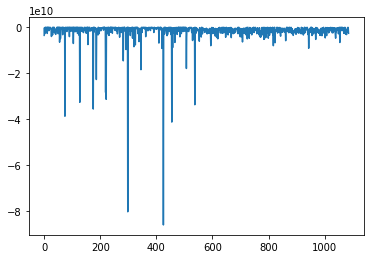

In [1543]:
plt.plot(test_score)

In [1458]:
diff_quantity_result[Ratio] = temp_result

In [1459]:
diff_quantity_result

{0.01: [0.7992633517495396, 0.8537477148080439],
 0.02: [0.8027906976744186, 0.8738574040219378],
 0.05: [0.8435700575815739, 0.8848263254113345],
 0.1: [0.8247213779128673, 0.8903107861060329]}

## 